### Import for days!
Let's pull all of the libraries we'll need  for the project

In [1]:
# will this ever be used... the world will never know
import tensorflow as tf

# scrape wiki plaintext
import wikipedia

# to view word freq dist
import matplotlib.pyplot
import tkinter

# store the articles so we don't annoy wikipedia (TODO)
# (might change to database storage later)
import _pickle as cPickle

# trying database storage :)!
import sqlite3

# make pretty progress bars
from tqdm import tnrange, tqdm_notebook
from time import sleep

# commonly used words...
import re
import os.path
import urllib.request

from stop_words import get_stop_words
import nltk

from nltk.corpus import stopwords

### Let's get a list of common words and put them in one list/set

__Todo__
* Try Different sizes of the set (only top 1,000 stop words?)

In [2]:
nltk.download("stopwords")
nltk.download("punkt")

test = stopwords.words('english')

common_words = get_stop_words(language='english', cache=True)

fn = '10k_common.txt'

# wow, so ethical!
if os.path.isfile(fn):
    print("already downloaded the common words list")
    myfile = open(fn, 'r')
    most_common = [line for line in myfile.readlines()]
else:
    print('Let me download that common word list file for you!')
    url = 'https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-usa.txt'
    urllib.request.urlretrieve(url, filename=fn)
    myfile = open(fn, 'r')
    most_common = [line.strip() for line in myfile.readlines()]
   
# Awesome, concat_list contains all of the unique common words

concat_list = list(set(s.lower().strip() for s in test + common_words + most_common))

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
already downloaded the common words list


### Now let's download a wiki article

__TO DO:__
* make a local article caching system

In [9]:
my_topic = "math"

article = wikipedia.page(title=my_topic,  auto_suggest=True, redirect=True, preload=False)

# article.content is text of info on the page
# article.link is a list of links
# for more info go here: https://pypi.python.org/pypi/wikipedia/

print("\n===================\nSuccessfully downloaded wiki article(",\
      my_topic ,  ")\n===================\n __SAMPLE__:\n",article.content[0:100],"...")


Successfully downloaded wiki article( math )
 __SAMPLE__:
 Mathematics (from Greek μάθημα máthēma, “knowledge, study, learning”) is the study of topics such as ...


### Do some processesing on the article

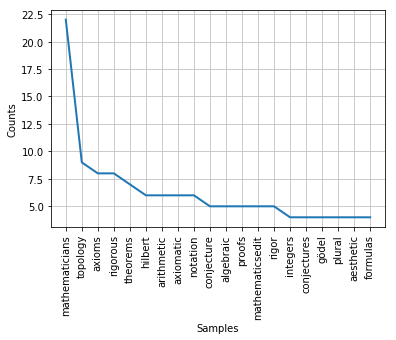


The top 20 uncommon words in the article on math are: 

('mathematicians', 22) 

('topology', 9) 

('axioms', 8) 

('rigorous', 8) 

('theorems', 7) 

('axiomatic', 6) 

('hilbert', 6) 

('arithmetic', 6) 

('notation', 6) 

('algebraic', 5) 

('conjecture', 5) 

('mathematicsedit', 5) 

('rigor', 5) 

('proofs', 5) 

('integers', 4) 

('conjectures', 4) 

('aesthetic', 4) 

('formulas', 4) 

('gödel', 4) 

('plural', 4) 



In [6]:
tokens = nltk.word_tokenize(article.content)

must_contain_some_letters = re.compile("[a-zA-Z]+") # assuming corpus is latin alphabet (can update this assumption later)

words = [w.lower() for w in tokens]

# remove "words" that are only comprised of symbols and numbers only
words = list(filter(must_contain_some_letters.match, words))

# remove stop words
words = [w for w in words if w not in concat_list]


fd = nltk.FreqDist(words) 
n = 20
fd.plot(n, cumulative=False) 



# sorts the most frequent words
top_n_best_words_omg = []
for w in set(words):
    top_n_best_words_omg.append((w, words.count(w)))

top_n_best_words_omg.sort(key=lambda x: x[1], reverse=True)
# sort by the second element in the tuple

print("\n===================\nThe top", n ,"uncommon words in the article on" , my_topic, "are: \n===================\n")
for i in range(n):
    print(top_n_best_words_omg[i],"\n")


### Found a pretrained model called Glove on the internets (it's a very large word embedding model)

Simply put, word embeddings are numeric vector representations of words.

An example of this would be -- let the word "apple" be represented by the vector [1,0] and let every other word be represented by [0,1].

Although this is a word embedding, clearly, we can do better.

To read more about how Glove is fit to the data ;) go to [stanford ...'s website](https://nlp.stanford.edu/projects/glove/)


### GLOVE IS HUGE (~6gig text file)

So we're going to store it in an sqlite3 database!

__TODO__:
* write helper functions for database: enter (unique) data, extract data


In [38]:
# Database helper function
def table_exists(file_name, table_name):
    connection = sqlite3.connect(file_name)
    cur = connection.cursor()
    table_name = (table_name,)
    cur.execute('SELECT COUNT(*) from sqlite_master where type = \'table\' and name = ? ', table_name )
    result = cur.fetchone()
    connection.close()
    return result[0] == 1

In [80]:
# table information

sqlite_file = 'word_embedding_project.sqlite'

# table info must be a list of tuples containing column name and type

table1_name = 'glove_word_embeddings'
table1_info = [('word','VARCHAR(50)')\
              ,('embedding','VARCHAR(1500)')]

table2_name = 'wiki_articles'
table2_info = [('title','content')]

In [103]:

def create_table(file_name, table_name, list_of_tuple_column_name_type):
    if table_exists(file_name,table_name):
        print("table \'{}\' already exists, carrying on".format(table_name))
    else :
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        print("opened...", table_name)
        
        exe = 'CREATE TABLE ' + table_name + ' (' + ', '.join([i[0] + ' ' +  i[1] for i in list_of_tuple_column_name_type]) + ' )'

        print('\n :: sending SQL :: ' + exe + '\n')     
        
        c.execute('{}'.format(exe) )
        connection.close()
        print("closed...", table_name)

def get_column_names(file_name,table_name):
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        print("\nopened table:", table_name)
        
        exe = 'PRAGMA TABLE_INFO({})'.format(table_name)
        
        print('\n :: sending SQL :: ' + exe + '\n')     
        c.execute('{}'.format(exe) )
        # result is a tuple, result[1] contains the table name
        names = [result[1] for result in c.fetchall()]
        
        connection.close()
        print("closed table: ", table_name , "\n")
        return names
        
def insert_data(file_name,table_name,list_of_tuple_column_name_data):
        connection = sqlite3.connect(file_name)
        c = connection.cursor()
        print("opened...", connection)
        
        exe = 'CREATE TABLE ' + table_name + ' (' + ', '.join([i[0] + ' ' +  i[1] for i in list_of_tuple_column_name_type]) + ' )'

        print('\n :: sending SQL :: ' + exe + '\n')     
        
        c.execute('{}'.format(exe) )
        connection.close()
        print("closed...", table_name)


In [104]:

create_table(sqlite_file,table1_name,table1_info)

create_table(sqlite_file,table2_name,table2_info)

get_column_names(sqlite_file,table1_name)

table 'glove_word_embeddings' already exists, carrying on
table 'wiki_articles' already exists, carrying on

opened table: glove_word_embeddings

 :: sending SQL :: PRAGMA TABLE_INFO(glove_word_embeddings)

closed table:  glove_word_embeddings 



['word', 'embedding']

__TODO__
* extract the embeddings of the common words dataset
* do tsne on the embeddings